# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Luca Fetz & Mohammed-Ismail Ben Salah 
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

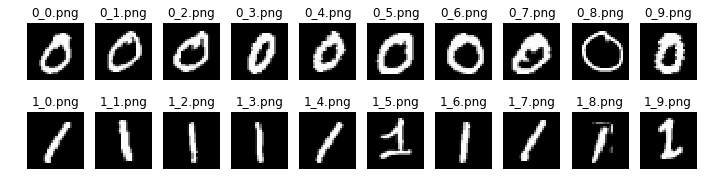

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion
look at slides 22 to 30 in lecture 4

good ideas:
binarize and apply fourier on every white point

use non maximum suppression/morphological skeleton and use fourier on the skeleton

less good ideas:
apply snake and apply fourier on contour

only keep frontier and apply fourier here

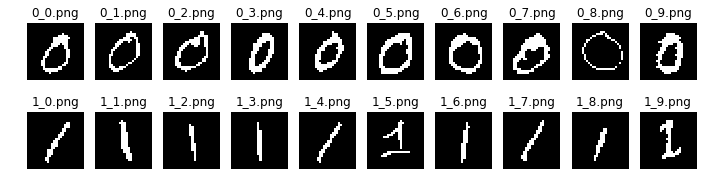

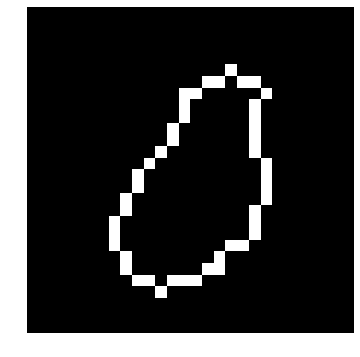

In [135]:
# u_k = x_k + j y_k
#from scipy.fftpack import fft, ifft
#
#fft(zeros_im[0]);
import numpy as np
import skimage.measure as mes

#extract number of images and number of pixels
N_images, N,tmp = zeros_im.shape


#binarize images and count number of points to be in descriptor
thres = 230
zeros_im_bin = zeros_im.copy()
for i in range(0,N_images):
    for j in range(0,N):
        for k in range(0,N):
            if zeros_im_bin[i][j,k] > thres:
                zeros_im_bin[i][j,k] = 255
            else:
                zeros_im_bin[i][j,k] = 0
                
ones_im_bin = ones_im.copy()
for i in range(0,N_images):
    for j in range(0,N):
        for k in range(0,N):
            if ones_im_bin[i][j,k] > thres:
                ones_im_bin[i][j,k] = 255
            else:
                ones_im_bin[i][j,k] = 0

#visualize binarization
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im_bin, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_bin, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#contour_zeros will be a list of lists of ndarrayw with the coordinates of the contour
#access it with contour_zeros[im_idx,arra_idx,]
contour_zeros = []
contour_ones = []
for i in range(0,N_images):
    contour_zeros.append(mes.find_contours(zeros_im_bin[i], 128, fully_connected='high', positive_orientation='low'))
    contour_ones.append(mes.find_contours(ones_im_bin[i], 128, fully_connected='high', positive_orientation='low'))
    
zeros_contour_im = np.zeros((N_images,N,N))
ones_contour_im = np.zeros((N_images,N,N))
for j in range(0,N_images):
    for i in range(0,len(contour_zeros[j][0])):
        zeros_contour_im[j,int(round(contour_zeros[j][0][i,0])),int(round(contour_zeros[j][0][i,1]))] = 255
    for i in range(0,len(contour_ones[j][0])):
        ones_contour_im[j,int(round(contour_ones[j][0][i,0])),int(round(contour_ones[j][0][i,1]))] = 255

#visualize one contour
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(zeros_contour_im[0], cmap='gray')
ax.axis('off')
plt.show()

#take the smallest contour and downsample the others with scipy.signal.decimate

#when all contours are the same size, take fft 

#plot ffts

In [147]:
nb_contour = np.zeros((N_images,N_images),np.uint)
print(len(contour_zeros[1][0]))


71


### 1.3 Additional method(s)
Add your implementation and discussion